In [1]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS
import sext_tools as st
from gen3_shared import prepare, get_eval_f, compute_family_k2l_from_knob_k2l, get_raw_eval_f

logger = logging.getLogger(__name__)

### SETUP

In [2]:
#MODE = 'BARE_SH1P12345_SH3_SH4_SL1_SL2_SL3_SVD0'
MODE = 'DW_SH1N_SH3N_SH4N_SL1N_SL2N_SL3N_SH1DW081828_SH3DW081828_SH4DW081828'
NAME_ROOT = f'moga_{MODE}_v1'

from apsopt.util.log import prepare_loggers
prepare_loggers()
fh = logging.FileHandler(f'logs/{NAME_ROOT}_{datetime.now():%Y%m%dT%H%M%S}.optlog', mode='w')
fh.setLevel(logging.NOTSET)
logging.getLogger().addHandler(fh)

dfknobs, ivals_ref, ivals, gvocs, iknobvals = prepare(MODE)
variables = gvocs.variables

reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

display(pd.DataFrame(ivals_ref,index=[0]))
display(pd.DataFrame(variables))

,SH1N,SH3N,SH4N,SL1N,SL2N,SL3N,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,3.966582,-1.171022,-3.16418,-2.654321,7.135584,-5.892172,3.966582,3.966582,3.966582,-1.171022,-1.171022,-1.171022,-3.16418,-3.16418,-3.16418


,SH1N,SH3N,SH4N,SL1N,SL2N,SL3N,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,-0.594987,-0.175653,-0.474627,-0.398148,-1.070338,-0.883826,-0.594987,-0.594987,-0.594987,-0.175653,-0.175653,-0.175653,-0.474627,-0.474627,-0.474627
1,0.594987,0.175653,0.474627,0.398148,1.070338,0.883826,0.594987,0.594987,0.594987,0.175653,0.175653,0.175653,0.474627,0.474627,0.474627


In [3]:
TEST_MODE = True
#@TEST_MODE = False

In [4]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, ivals, True)
inputs_dict

SH1N   : +3.967 + -0.595 -> +3.372
SH3N   : -1.171 + -0.176 -> -1.347
SH4N   : -3.164 + -0.475 -> -3.639
SL1N   : -2.654 + -0.398 -> -3.052
SL2N   : +7.136 + -1.070 -> +6.065
SL3N   : -5.892 + -0.884 -> -6.776
SH1-DW08: +3.967 + -0.595 -> +3.372
SH1-DW18: +3.967 + -0.595 -> +3.372
SH1-DW28: +3.967 + -0.595 -> +3.372
SH3-DW08: -1.171 + -0.176 -> -1.347
SH3-DW18: -1.171 + -0.176 -> -1.347
SH3-DW28: -1.171 + -0.176 -> -1.347
SH4-DW08: -3.164 + -0.475 -> -3.639
SH4-DW18: -3.164 + -0.475 -> -3.639
SH4-DW28: -3.164 + -0.475 -> -3.639


{'SH1N': 3.3715950570000004,
 'SH3N': -1.3466749343,
 'SH4N': -3.6388071633,
 'SL1N': -3.0524693915000003,
 'SL2N': 6.0652466465,
 'SL3N': -6.775997940300001,
 'SH1-DW08': 3.3715950570000004,
 'SH1-DW18': 3.3715950570000004,
 'SH1-DW28': 3.3715950570000004,
 'SH3-DW08': -1.3466749343,
 'SH3-DW18': -1.3466749343,
 'SH3-DW28': -1.3466749343,
 'SH4-DW08': -3.6388071633,
 'SH4-DW18': -3.6388071633,
 'SH4-DW28': -3.6388071633}

### Test eval function

In [5]:
# Test
if True and not TEST_MODE:
    raw_eval_f = get_raw_eval_f()
    raw_eval_f(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

In [6]:
eval_f = get_eval_f(TEST_MODE, gvocs, dfknobs)
ev = FunctionEvaluator(script=eval_f)

generator_name = 'aps_moga'
gc = get_generator_class(generator_name)
gen = gc(gvocs=gvocs)
POP_SIZE = 8
gen.population_size = POP_SIZE
gen.reference_point = reference_point

[INFO ][17:30:33.606    moga.py   24] Initializing generator aps_moga
[INFO ][17:30:33.607 generator.   64] Initialized generator aps_moga
[INFO ][17:30:33.608   cnsga.py  283] Created toolbox with 15 variables, 0 constraints, and 2 objectives.
[INFO ][17:30:33.609   cnsga.py  286]     Using selection algorithm: nsga2


In [7]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options, generator=gen, evaluator=ev, gvocs=gvocs)

[DEBUG][17:30:33.619 optimizer.   83] Initializing optimizer with tag='0d5b666fc4' store_history=True dump_every_step=True history_directory=None execution_mode='sync'
[DEBUG][17:30:33.620 optimizer.  138] Generator set to: supports_batch_generation=False supports_multi_objective=True vocs=VOCS(variables={'SH1N': [-0.594987363, 0.594987363], 'SH3N': [-0.17565325229999998, 0.17565325229999998], 'SH4N': [-0.4746270213, 0.4746270213], 'SL1N': [-0.39814818150000003, 0.39814818150000003], 'SL2N': [-1.0703376435, 1.0703376435], 'SL3N': [-0.8838258183000001, 0.8838258183000001], 'SH1-DW08': [-0.594987363, 0.594987363], 'SH1-DW18': [-0.594987363, 0.594987363], 'SH1-DW28': [-0.594987363, 0.594987363], 'SH3-DW08': [-0.17565325229999998, 0.17565325229999998], 'SH3-DW18': [-0.17565325229999998, 0.17565325229999998], 'SH3-DW28': [-0.17565325229999998, 0.17565325229999998], 'SH4-DW08': [-0.4746270213, 0.4746270213], 'SH4-DW18': [-0.4746270213, 0.4746270213], 'SH4-DW28': [-0.4746270213, 0.4746270213]

### Sample at initial values

In [8]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][17:30:33.645 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:33.647 evaluators  193] Data kwargs: row={'SH1N': 0.0, 'SH3N': 0.0, 'SH4N': 0.0, 'SL1N': 0.0, 'SL2N': 0.0, 'SL3N': 0.0, 'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.0, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[DEBUG][17:30:33.648 evaluators  211] Result: output={'result': {'LT': 0.059650786885545495, 'EFF': -0.06912151152518736, '_nux': 0.584610372618923, '_nuy': -0.43023189586315513, '_eps_x_bxbOn': 1.5309788807898077, '_eps_y_bxbOn': -0.8095998750044586}, 'exception': None, 'traceback': '', 'wall_time': 0.00013749999925494194, 'cpu_time': 0.0}
[DEBUG][17:30:33.650 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:33.659 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00000.json] in [0.00611]s


MOGA add_data (+1): len(self._offspring)=1/8


In [9]:
assert opt.data.iloc[0].valid, f'ERROR: {opt.data.iloc[0].traceback}'
opt.data

,SH1N,SH3N,SH4N,SL1N,SL2N,SL3N,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,traceback,wall_time,cpu_time,valid,LT,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,,0.000137,0.0,True,0.059651,-0.069122,0.58461,-0.430232,1.530979,-0.8096


### Sample close to initial point

In [10]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=POP_SIZE-1, point=iknobvals, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

[INFO ][17:30:33.718 optimizer.  573] Evaluating 7 inputs
[DEBUG][17:30:33.721 evaluators  193] Data kwargs: row={'SH1-DW08': -0.012186532692933526, 'SH1-DW18': 0.021491343027128244, 'SH1-DW28': -0.010107923375197163, 'SH1N': 0.00727535507218215, 'SH3-DW08': -0.0004228525333871344, 'SH3-DW18': -0.004754334608170229, 'SH3-DW28': 0.0021117702840900334, 'SH3N': -0.0032764048380728933, 'SH4-DW08': 0.015611910094869175, 'SH4-DW18': 0.005358964909056976, 'SH4-DW28': -0.0005460131223591937, 'SH4N': 0.0018385672171622007, 'SL1N': -0.0013592640579865103, 'SL2N': 0.0035203112492618455, 'SL3N': -0.0029785343937742542}
[DEBUG][17:30:33.722 evaluators  211] Result: output={'result': {'LT': 0.09380295328358842, 'EFF': 9.408402900574231, '_nux': 0.28184988023914986, '_nuy': -1.468081900194077, '_eps_x_bxbOn': -0.5856689640931845, '_eps_y_bxbOn': -1.3706644451765029}, 'exception': None, 'traceback': '', 'wall_time': 9.66999214142561e-05, 'cpu_time': 0.0}
[DEBUG][17:30:33.722 evaluators  193] Data kwar

MOGA add_data (+7): len(self._offspring)=8/8
MOGA add_data: creating next generation


In [11]:
opt.data

,SH1N,SH3N,SH4N,SL1N,SL2N,SL3N,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,traceback,wall_time,cpu_time,valid,LT,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,,0.000137,0.0,True,0.059651,-0.069122,0.584610,-0.430232,1.530979,-0.809600
2,0.007275,-0.003276,0.001839,-0.001359,0.003520,-0.002979,-0.012187,0.021491,-0.010108,-0.000423,...,,0.000097,0.0,True,0.093803,9.408403,0.281850,-1.468082,-0.585669,-1.370664
3,-0.013607,0.007010,-0.012991,0.001392,-0.015322,0.018557,0.007942,-0.009508,0.024360,0.002330,...,,0.000088,0.0,True,-0.117676,16.452778,-0.532134,0.259526,-0.024198,-0.696398
4,0.020145,0.003699,-0.000111,-0.015998,0.029138,0.043712,0.016892,0.000493,-0.024948,0.008058,...,,0.000090,0.0,True,0.073175,21.105389,0.798353,0.014362,-1.612822,0.061961
5,-0.026826,-0.008512,0.014719,0.015953,-0.044109,-0.023472,-0.022064,-0.027556,0.009505,-0.005675,...,,0.000062,0.0,True,-0.248973,24.310371,-1.352867,-0.005383,-0.579585,0.761976
6,-0.017657,0.001219,0.019720,-0.013885,-0.005994,-0.036449,-0.024365,0.014675,0.019705,-0.007896,...,,0.000077,0.0,True,-0.276664,21.130116,-1.570585,0.169272,-0.083593,-0.862173
7,0.025622,-0.006051,-0.006981,0.013847,0.014465,0.029329,0.029422,-0.017594,-0.005457,0.005818,...,,0.000062,0.0,True,0.098412,20.127631,1.247242,-2.484566,-1.807260,1.939981
8,-0.000487,-0.000816,-0.018389,-0.008577,-0.028242,0.010940,0.004669,0.022608,0.004854,0.000023,...,,0.000055,0.0,True,0.072362,15.660179,2.222804,-0.115321,-0.799541,0.077387


### Run optimizer

In [12]:
opt.step()

[DEBUG][17:30:33.791 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:33.795 optimizer.  488] Generated 1 inputs
[INFO ][17:30:33.799 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:33.801 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH1N': -0.0004837405794058603, 'SH3-DW08': 0.0, 'SH3-DW18': 0.00687306709268245, 'SH3-DW28': 0.0, 'SH3N': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': -0.0003611619488366434, 'SH4-DW28': 0.0004448254148917835, 'SH4N': 0.0, 'SL1N': -1.7428258195830056e-05, 'SL2N': -0.02735815703612076, 'SL3N': -7.741107430763675e-05}
[DEBUG][17:30:33.801 evaluators  211] Result: output={'result': {'LT': -0.4107896985224866, 'EFF': 3.566940662763362, '_nux': -0.8699680607849543, '_nuy': 0.5656347062148603, '_eps_x_bxbOn': 1.4154778883492174, '_eps_y_bxbOn': 0.9946888332208742}, 'exception': None, 'traceback': '', 'wall_time': 6.97999494150281e-05, 'cpu_time': 0.0}
[DEBUG][17:30:33.803 optimizer.  291] Adding (1) new data to internal da

MOGA add_data (+1): len(self._offspring)=1/8


In [13]:
for i in range(50):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()

[DEBUG][17:30:33.828 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:33.828 optimizer.  488] Generated 1 inputs
[INFO ][17:30:33.834 optimizer.  573] Evaluating 1 inputs



** Step #1 at 2023-12-16 17:30:33**



[DEBUG][17:30:33.836 evaluators  193] Data kwargs: row={'SH1-DW08': 0.00466872448194618, 'SH1-DW18': 0.022607509724586524, 'SH1-DW28': 0.004853607274617772, 'SH1N': -3.1809439269104374e-06, 'SH3-DW08': 2.292886212730723e-05, 'SH3-DW18': 0.0002894965435815879, 'SH3-DW28': 0.0033293331116083843, 'SH3N': -0.0008157876740557488, 'SH4-DW08': 0.02311121759245721, 'SH4-DW18': 0.01630698777749955, 'SH4-DW28': -0.008176338921313413, 'SH4N': -0.018389172885442576, 'SL1N': -0.008560041558510041, 'SL2N': -0.0008834590169583059, 'SL3N': 0.011016917818067733}
[DEBUG][17:30:33.836 evaluators  211] Result: output={'result': {'LT': 0.28033933583471626, 'EFF': 12.270229971112057, '_nux': 0.5841549624003319, '_nuy': -1.3750717706753912, '_eps_x_bxbOn': -0.9973709163775463, '_eps_y_bxbOn': -1.9082502093984026}, 'exception': None, 'traceback': '', 'wall_time': 8.349993731826544e-05, 'cpu_time': 0.0}
[DEBUG][17:30:33.838 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:33.856 optimi

MOGA add_data (+1): len(self._offspring)=2/8

** Step #2 at 2023-12-16 17:30:33**

MOGA add_data (+1): len(self._offspring)=3/8

** Step #3 at 2023-12-16 17:30:33**

MOGA add_data (+1): len(self._offspring)=4/8

** Step #4 at 2023-12-16 17:30:33**

MOGA add_data (+1): len(self._offspring)=5/8


[DEBUG][17:30:33.944 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00006.json] in [0.01820]s
[DEBUG][17:30:33.945 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:33.945 optimizer.  488] Generated 1 inputs
[INFO ][17:30:33.949 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:33.951 evaluators  193] Data kwargs: row={'SH1-DW08': -0.027983774968811517, 'SH1-DW18': -0.032976180286837825, 'SH1-DW28': -0.007755989642052203, 'SH1N': 0.025622471048499, 'SH3-DW08': 0.014817449438773857, 'SH3-DW18': 0.003564752156007118, 'SH3-DW28': -0.006534408397527235, 'SH3N': -0.006050945571236106, 'SH4-DW08': 0.006557975539853794, 'SH4-DW18': -0.04030812793492321, 'SH4-DW28': -0.02314651623347587, 'SH4N': -0.006980621682058492, 'SL1N': -0.014665703749666985, 'SL2N': 0.014222017577718118, 'SL3N': 0.02932949217909126}
[DEBUG][17:30:33.952 evaluators  211] Result: output={'result': {'LT': -0.6378765467005175, 'EFF': 26.13842634514868


** Step #5 at 2023-12-16 17:30:33**

MOGA add_data (+1): len(self._offspring)=6/8

** Step #6 at 2023-12-16 17:30:33**

MOGA add_data (+1): len(self._offspring)=7/8


[DEBUG][17:30:34.006 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00008.json] in [0.02113]s
[DEBUG][17:30:34.007 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.008 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.013 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:34.015 evaluators  193] Data kwargs: row={'SH1-DW08': 0.016179778765023543, 'SH1-DW18': -0.0013286195222217499, 'SH1-DW28': -0.027042413378332953, 'SH1N': 0.02014536548643869, 'SH3-DW08': -0.006396037179903181, 'SH3-DW18': -0.0023210806529579235, 'SH3-DW28': -0.006803271111803477, 'SH3N': 0.0036986962614515752, 'SH4-DW08': -0.019949410166368652, 'SH4-DW18': 0.018106623673661795, 'SH4-DW28': 0.011474621004894589, 'SH4N': -0.00011076031618147478, 'SL1N': -0.015997786983084572, 'SL2N': -0.043805109436892836, 'SL3N': 0.044751247126712926}
[DEBUG][17:30:34.015 evaluators  211] Result: output={'result': {'LT': -0.28772780352169836, 'EFF': 23.786


** Step #7 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation


[DEBUG][17:30:34.047 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.051 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.055 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:34.057 evaluators  193] Data kwargs: row={'SH1-DW08': 0.016891571335294984, 'SH1-DW18': 0.0004925675788774488, 'SH1-DW28': -0.02494823340293067, 'SH1N': 0.02014536548643869, 'SH3-DW08': -0.0535377262061795, 'SH3-DW18': 0.005033199578330849, 'SH3-DW28': 0.0050703996529853496, 'SH3N': 0.0036986962614515752, 'SH4-DW08': -0.019949410166368652, 'SH4-DW18': -0.006527886294008238, 'SH4-DW28': 0.011474621004894589, 'SH4N': -0.00011076031618147478, 'SL1N': -0.015997786983084572, 'SL2N': 0.029138217702757985, 'SL3N': 0.04371168524183496}
[DEBUG][17:30:34.057 evaluators  211] Result: output={'result': {'LT': -0.21835205902313803, 'EFF': 25.605353523615623, '_nux': -0.4706385990328461, '_nuy': -1.3185570649641556, '_eps_x_bxbOn': 0.27887002424635277, '_eps_y_bxbOn': 0.08974853167674812}, 'exception': None, 'tr


** Step #8 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=1/8

** Step #9 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=2/8

** Step #10 at 2023-12-16 17:30:34**



[DEBUG][17:30:34.131 evaluators  193] Data kwargs: row={'SH1-DW08': 0.033705805898573984, 'SH1-DW18': 0.02210261735981054, 'SH1-DW28': 0.0705573874876525, 'SH1N': 0.00016235429441606442, 'SH3-DW08': -0.001240374012894366, 'SH3-DW18': -0.006892545735429833, 'SH3-DW28': 0.003448977529139663, 'SH3N': 0.001173282621321071, 'SH4-DW08': -0.011501992458251946, 'SH4-DW18': 0.019452549017148678, 'SH4-DW28': 0.0035760781248407036, 'SH4N': 0.019720468596321053, 'SL1N': 0.014627766040454957, 'SL2N': -0.005842720069098935, 'SL3N': -0.03644946205649103}
[DEBUG][17:30:34.132 evaluators  211] Result: output={'result': {'LT': 0.5402382888852832, 'EFF': 24.96499842603678, '_nux': 0.4377186946623262, '_nuy': -0.7330444870850148, '_eps_x_bxbOn': 0.556918766397698, '_eps_y_bxbOn': 0.9818347092958227}, 'exception': None, 'traceback': '', 'wall_time': 8.549995254725218e-05, 'cpu_time': 0.0}
[DEBUG][17:30:34.133 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:34.157 optimizer. 1286] 

MOGA add_data (+1): len(self._offspring)=3/8

** Step #11 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=4/8


[DEBUG][17:30:34.199 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.200 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.205 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:34.208 evaluators  193] Data kwargs: row={'SH1-DW08': 0.008060673945362813, 'SH1-DW18': -0.009508462673219236, 'SH1-DW28': 0.02435954071773454, 'SH1N': -0.013137592730860896, 'SH3-DW08': -0.005668739471142697, 'SH3-DW18': 0.0010443587571693298, 'SH3-DW28': -0.0037425250864202998, 'SH3N': -0.002802864007078952, 'SH4-DW08': 0.002384650430415071, 'SH4-DW18': -0.017747639842811448, 'SH4-DW28': -0.01665239498812785, 'SH4N': 0.014245621843006762, 'SL1N': 0.0013918847867016547, 'SL2N': -0.01404896731832678, 'SL3N': -0.2384810858665987}
[DEBUG][17:30:34.209 evaluators  211] Result: output={'result': {'LT': -1.4934277244239182, 'EFF': 37.30717942519519, '_nux': 0.9806906891357612, '_nuy': -0.8801480202264065, '_eps_x_bxbOn': 0.22176639334224535, '_eps_y_bxbOn': -0.3395967013206528}, 'exception': None, 'trac


** Step #12 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=5/8


[DEBUG][17:30:34.246 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00014.json] in [0.03071]s
[DEBUG][17:30:34.247 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.248 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.253 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:34.255 evaluators  193] Data kwargs: row={'SH1-DW08': -0.022182371956397096, 'SH1-DW18': -0.027555711199900395, 'SH1-DW28': 0.0095050111734756, 'SH1N': -0.027294845018040602, 'SH3-DW08': 0.0021758821635157154, 'SH3-DW18': -0.0021177309048571796, 'SH3-DW28': -0.006709530050164829, 'SH3N': -0.00877838415594022, 'SH4-DW08': -0.009908712513876542, 'SH4-DW18': 0.11214284297001119, 'SH4-DW28': 0.020902761832797566, 'SH4N': -0.011741370392367698, 'SL1N': 0.01595293979873218, 'SL2N': -0.044109109087805506, 'SL3N': -0.023472380931576234}
[DEBUG][17:30:34.255 evaluators  211] Result: output={'result': {'LT': 0.10937087004618379, 'EFF': 34.4600645292


** Step #13 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=6/8

** Step #14 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=7/8

** Step #15 at 2023-12-16 17:30:34**



[DEBUG][17:30:34.333 evaluators  211] Result: output={'result': {'LT': 0.007791707547083249, 'EFF': 14.856751846929518, '_nux': 0.32174885637250566, '_nuy': -0.23373811242914738, '_eps_x_bxbOn': -0.6994732739492994, '_eps_y_bxbOn': 0.36919870646444763}, 'exception': None, 'traceback': '', 'wall_time': 7.859990000724792e-05, 'cpu_time': 0.0}
[DEBUG][17:30:34.334 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:34.371 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00017.json] in [0.03006]s
[DEBUG][17:30:34.372 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.376 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.380 optimizer.  573] Evaluating 1 inputs


MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation

** Step #16 at 2023-12-16 17:30:34**



[DEBUG][17:30:34.382 evaluators  193] Data kwargs: row={'SH1-DW08': -0.02178150537944462, 'SH1-DW18': -0.027555711199900395, 'SH1-DW28': 0.009304221916972805, 'SH1N': 0.008451511332638556, 'SH3-DW08': -0.005674985261210925, 'SH3-DW18': -0.0021177309048571796, 'SH3-DW28': 0.0019004919962315068, 'SH3N': -0.008918529453586854, 'SH4-DW08': 0.015047945779784378, 'SH4-DW18': 0.01787670697486246, 'SH4-DW28': 0.0018013604408626815, 'SH4N': 0.01471910384767805, 'SL1N': 0.01595293979873218, 'SL2N': -0.04396992879115255, 'SL3N': -0.023472380931576234}
[DEBUG][17:30:34.382 evaluators  211] Result: output={'result': {'LT': -0.4474114285535523, 'EFF': 21.86796334558926, '_nux': -0.5266350239852615, '_nuy': -1.2322105463336162, '_eps_x_bxbOn': 0.5340917329244463, '_eps_y_bxbOn': -0.1380366329557144}, 'exception': None, 'traceback': '', 'wall_time': 8.059991523623466e-05, 'cpu_time': 0.0}
[DEBUG][17:30:34.384 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:34.416 optimizer. 1

MOGA add_data (+1): len(self._offspring)=1/8

** Step #17 at 2023-12-16 17:30:34**



[DEBUG][17:30:34.427 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:34.460 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00019.json] in [0.03025]s
[DEBUG][17:30:34.461 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.463 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.467 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:34.468 evaluators  193] Data kwargs: row={'SH1-DW08': 0.016891571335294984, 'SH1-DW18': 0.0004925675788774488, 'SH1-DW28': -0.02494823340293067, 'SH1N': 0.02014536548643869, 'SH3-DW08': -0.0535377262061795, 'SH3-DW18': 0.004933195026904388, 'SH3-DW28': 0.02824937924487186, 'SH3N': 0.0036986962614515752, 'SH4-DW08': -0.019949410166368652, 'SH4-DW18': -0.04055078676779028, 'SH4-DW28': 0.012135258017897218, 'SH4N': -0.006807335311920527, 'SL1N': -0.01611582386290439, 'SL2N': 0.029138217702757985, 'SL3N': 0.04371168524183496}
[DEBUG][17:30:34.469 evaluators  211] 

MOGA add_data (+1): len(self._offspring)=2/8

** Step #18 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=3/8

** Step #19 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=4/8


[DEBUG][17:30:34.561 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00021.json] in [0.04502]s
[DEBUG][17:30:34.564 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.565 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.570 optimizer.  573] Evaluating 1 inputs



** Step #20 at 2023-12-16 17:30:34**



[DEBUG][17:30:34.571 evaluators  193] Data kwargs: row={'SH1-DW08': 0.029278820435011784, 'SH1-DW18': -0.017593543599977633, 'SH1-DW28': -0.0060296207885064575, 'SH1N': 0.025622471048499, 'SH3-DW08': 0.015660649572593336, 'SH3-DW18': -0.0018442099775122745, 'SH3-DW28': -0.00671128478232774, 'SH3N': -0.006057780216279357, 'SH4-DW08': 0.00424622834380527, 'SH4-DW18': -0.02320468158268241, 'SH4-DW28': -0.022962175670478188, 'SH4N': -0.006980621682058492, 'SL1N': 0.03950831157076709, 'SL2N': 0.01446513280879444, 'SL3N': 0.029933992426930216}
[DEBUG][17:30:34.572 evaluators  211] Result: output={'result': {'LT': 0.32686569080764977, 'EFF': 24.94497080410219, '_nux': 1.447304584564681, '_nuy': 0.5512814909266643, '_eps_x_bxbOn': 0.027991987343796272, '_eps_y_bxbOn': 0.25269717096022953}, 'exception': None, 'traceback': '', 'wall_time': 9.570003021508455e-05, 'cpu_time': 0.0}
[DEBUG][17:30:34.573 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:34.609 optimizer. 1286]

MOGA add_data (+1): len(self._offspring)=5/8

** Step #21 at 2023-12-16 17:30:34**



[DEBUG][17:30:34.617 evaluators  193] Data kwargs: row={'SH1-DW08': -0.022039007114212184, 'SH1-DW18': -0.027555711199900395, 'SH1-DW28': 0.010077437076236814, 'SH1N': -0.027294845018040602, 'SH3-DW08': 0.0019387067117531027, 'SH3-DW18': 0.003291231228662213, 'SH3-DW28': -0.005477628550019642, 'SH3N': -0.008771549510896967, 'SH4-DW08': -0.009908712513876542, 'SH4-DW18': 0.11214284297001119, 'SH4-DW28': 0.0201343634723564, 'SH4N': -0.011741370392367698, 'SL1N': 0.013808113192152926, 'SL2N': -0.044109109087805506, 'SL3N': -0.02407688117941519}
[DEBUG][17:30:34.618 evaluators  211] Result: output={'result': {'LT': -0.141239136932383, 'EFF': 34.20962286821969, '_nux': -0.7323943275961122, '_nuy': 0.23521868925494394, '_eps_x_bxbOn': -0.7411064829366744, '_eps_y_bxbOn': 0.14052424203570116}, 'exception': None, 'traceback': '', 'wall_time': 8.290004916489124e-05, 'cpu_time': 0.0}
[DEBUG][17:30:34.619 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:34.660 optimizer. 

MOGA add_data (+1): len(self._offspring)=6/8

** Step #22 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=7/8

** Step #23 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation


[DEBUG][17:30:34.758 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00025.json] in [0.03512]s
[DEBUG][17:30:34.758 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.763 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.767 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:34.769 evaluators  193] Data kwargs: row={'SH1-DW08': 0.029722365380598716, 'SH1-DW18': -0.017593543599977633, 'SH1-DW28': 0.01073545302997243, 'SH1N': -0.02764268353863064, 'SH3-DW08': 0.015660649572593336, 'SH3-DW18': -0.0018442099775122745, 'SH3-DW28': -0.00671128478232774, 'SH3N': -0.006057780216279357, 'SH4-DW08': -0.009997983566107742, 'SH4-DW18': -0.024522679026433354, 'SH4-DW28': -0.022962175670478188, 'SH4N': -0.006980621682058492, 'SL1N': 0.03950831157076709, 'SL2N': -0.04669761657561145, 'SL3N': 0.029933992426930216}



** Step #24 at 2023-12-16 17:30:34**



[DEBUG][17:30:34.770 evaluators  211] Result: output={'result': {'LT': -0.027972361485645136, 'EFF': 29.66069163327209, '_nux': -0.7552773408859745, '_nuy': -0.06972557461482785, '_eps_x_bxbOn': 0.5410223702945403, '_eps_y_bxbOn': -0.4985691070736488}, 'exception': None, 'traceback': '', 'wall_time': 0.00010369997471570969, 'cpu_time': 0.0}
[DEBUG][17:30:34.772 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:34.809 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00026.json] in [0.03470]s
[DEBUG][17:30:34.810 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.811 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.816 optimizer.  573] Evaluating 1 inputs


MOGA add_data (+1): len(self._offspring)=1/8

** Step #25 at 2023-12-16 17:30:34**



[DEBUG][17:30:34.817 evaluators  193] Data kwargs: row={'SH1-DW08': -0.022482552059799116, 'SH1-DW18': -0.027555711199900395, 'SH1-DW28': -0.006687636742242074, 'SH1N': 0.025970309569089037, 'SH3-DW08': 0.0019387067117531027, 'SH3-DW18': 0.003291231228662213, 'SH3-DW28': -0.005477628550019642, 'SH3N': -0.008771549510896967, 'SH4-DW08': 0.00433549939603647, 'SH4-DW18': 0.11346084041376214, 'SH4-DW28': 0.0201343634723564, 'SH4N': -0.011741370392367698, 'SL1N': 0.013808113192152926, 'SL2N': 0.017053640296600385, 'SL3N': -0.02407688117941519}
[DEBUG][17:30:34.818 evaluators  211] Result: output={'result': {'LT': 0.24031331042390444, 'EFF': 30.712801144386756, '_nux': 1.2018830091885695, '_nuy': -1.9460539702185868, '_eps_x_bxbOn': -0.43784958735090945, '_eps_y_bxbOn': -0.4622268838033456}, 'exception': None, 'traceback': '', 'wall_time': 0.00010740000288933516, 'cpu_time': 0.0}
[DEBUG][17:30:34.819 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:34.856 optimizer. 

MOGA add_data (+1): len(self._offspring)=2/8

** Step #26 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=3/8

** Step #27 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=4/8


[DEBUG][17:30:34.949 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.950 optimizer.  488] Generated 1 inputs
[INFO ][17:30:34.955 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:34.956 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03543296583601775, 'SH1-DW18': -0.011798043489558305, 'SH1-DW28': 0.06843891249950822, 'SH1N': 0.001077077382096018, 'SH3-DW08': -0.001240374012894366, 'SH3-DW18': -0.007296892400940559, 'SH3-DW28': 0.003347382332316748, 'SH3N': -0.0025576036510818858, 'SH4-DW08': 0.002466133413675053, 'SH4-DW18': 0.019611427900400463, 'SH4-DW28': -0.01613191169540229, 'SH4N': 0.019401526410113334, 'SL1N': 0.0025442390144855814, 'SL2N': -0.0025299308386911856, 'SL3N': -0.039309565804289195}
[DEBUG][17:30:34.957 evaluators  211] Result: output={'result': {'LT': 0.5672930115900245, 'EFF': 23.331706196716322, '_nux': 1.7770052765072812, '_nuy': -0.32294711950876903, '_eps_x_bxbOn': 0.5232709473696424, '_eps_y_bxbOn': -1.3554998631142707}, 'exception': None, 'trac


** Step #28 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=5/8


[DEBUG][17:30:34.996 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00030.json] in [0.03651]s
[DEBUG][17:30:34.997 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:34.998 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.002 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.004 evaluators  193] Data kwargs: row={'SH1-DW08': 0.04058578253314835, 'SH1-DW18': 0.043245852568487494, 'SH1-DW28': 0.026478015705878825, 'SH1N': -0.014052315818540849, 'SH3-DW08': -0.005668739471142697, 'SH3-DW18': 0.0014487054226800548, 'SH3-DW28': -0.0036409298895973847, 'SH3N': 0.0009280222653240048, 'SH4-DW08': -0.011583475441511929, 'SH4-DW18': -0.017906518726063234, 'SH4-DW28': 0.0030555948321151407, 'SH4N': 0.01456456402921448, 'SL1N': 0.07737023517965295, 'SL2N': 0.11260891753557732, 'SL3N': -0.23562098211880056}
[DEBUG][17:30:35.005 evaluators  211] Result: output={'result': {'LT': -0.12535674413839965, 'EFF': 60.86357885810


** Step #29 at 2023-12-16 17:30:34**

MOGA add_data (+1): len(self._offspring)=6/8


[DEBUG][17:30:35.050 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00031.json] in [0.04155]s
[DEBUG][17:30:35.051 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.052 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.056 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.058 evaluators  193] Data kwargs: row={'SH1-DW08': -0.022182371956397096, 'SH1-DW18': -0.027555711199900395, 'SH1-DW28': 0.0095050111734756, 'SH1N': -0.027294845018040602, 'SH3-DW08': 0.0021758821635157154, 'SH3-DW18': -0.0021177309048571796, 'SH3-DW28': -0.046318577068590654, 'SH3N': -0.00877838415594022, 'SH4-DW08': -0.009908712513876542, 'SH4-DW18': 0.11214284297001119, 'SH4-DW28': 0.020902761832797566, 'SH4N': -0.015884177359913317, 'SL1N': 0.01595293979873218, 'SL2N': -0.044109109087805506, 'SL3N': -0.023472380931576234}
[DEBUG][17:30:35.058 evaluators  211] Result: output={'result': {'LT': -0.24106321297670788, 'EFF': 38.845002183


** Step #30 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=7/8

** Step #31 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation


[DEBUG][17:30:35.159 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00033.json] in [0.04139]s
[DEBUG][17:30:35.160 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.164 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.169 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.170 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03544021453056427, 'SH1-DW18': -0.01100332449377311, 'SH1-DW28': 0.025100276758727752, 'SH1N': 0.00022980359063855976, 'SH3-DW08': -0.005622152100251651, 'SH3-DW18': 0.0017595188885365844, 'SH3-DW28': 0.0033243635574749563, 'SH3N': -0.002802891312284342, 'SH4-DW08': 0.002384650430415071, 'SH4-DW18': 0.019641434300391065, 'SH4-DW28': 0.002857206061217351, 'SH4N': 0.014245621843006762, 'SL1N': 0.013475411812671029, 'SL2N': -0.0040312335944345384, 'SL3N': -0.05751608612103701}
[DEBUG][17:30:35.171 evaluators  211] Result: output={'result': {'LT': 0.05030942423019126, 'EFF': 19.9915558253


** Step #32 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=1/8


[DEBUG][17:30:35.214 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00034.json] in [0.03863]s
[DEBUG][17:30:35.214 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.215 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.219 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.221 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0333513296377483, 'SH1-DW18': 0.007775409082722146, 'SH1-DW28': 0.06843891249950822, 'SH1N': 0.0010660398803324044, 'SH3-DW08': -0.001286961383785412, 'SH3-DW18': -0.007607705866797088, 'SH3-DW28': -0.0036179111147555927, 'SH3N': -0.002557576345876495, 'SH4-DW08': 0.002466133413675053, 'SH4-DW18': -0.01777764624280205, 'SH4-DW28': -0.022484434754509744, 'SH4N': 0.019401526410113334, 'SL1N': 0.0025442390144855814, 'SL2N': 0.11742300952172842, 'SL3N': -0.2202745655498509}
[DEBUG][17:30:35.222 evaluators  211] Result: output={'result': {'LT': -0.5063632439276557, 'EFF': 52.70701561324453


** Step #33 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=2/8


[DEBUG][17:30:35.265 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00035.json] in [0.04006]s
[DEBUG][17:30:35.266 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.267 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.272 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.273 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03397741886761485, 'SH1-DW18': 0.05525569273526668, 'SH1-DW28': 0.0705573874876525, 'SH1N': 0.00016235429441606442, 'SH3-DW08': -0.0010646489618087573, 'SH3-DW18': -0.006654399921699073, 'SH3-DW28': -0.003523330015054515, 'SH3N': 0.001173282621321071, 'SH4-DW08': -0.011501992458251946, 'SH4-DW18': 0.019452549017148678, 'SH4-DW28': 0.0035760781248407036, 'SH4N': 0.019720468596321053, 'SL1N': 0.07581321061912885, 'SL2N': -0.005842720069098935, 'SL3N': -0.03644946205649103}
[DEBUG][17:30:35.274 evaluators  211] Result: output={'result': {'LT': 0.4831848967573837, 'EFF': 34.42764172137679


** Step #34 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=3/8

** Step #35 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=4/8


[DEBUG][17:30:35.369 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00037.json] in [0.04005]s
[DEBUG][17:30:35.369 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.370 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.374 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.375 evaluators  193] Data kwargs: row={'SH1-DW08': -0.09000541330460743, 'SH1-DW18': -0.027555711199900395, 'SH1-DW28': -0.006687636742242074, 'SH1N': 0.025970309569089037, 'SH3-DW08': 0.0020207142106123, 'SH3-DW18': -0.007333332818336523, 'SH3-DW28': -0.005413604426739365, 'SH3N': -0.008968535681446121, 'SH4-DW08': -0.011420089213899975, 'SH4-DW18': 0.02003336646826892, 'SH4-DW28': -0.015928579527626146, 'SH4N': 0.020134228289116922, 'SL1N': 0.002675137305367741, 'SL2N': 0.017053640296600385, 'SL3N': -0.037408087442236046}
[DEBUG][17:30:35.376 evaluators  211] Result: output={'result': {'LT': -0.5257005766776085, 'EFF': 29.854361026976


** Step #36 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=5/8


[DEBUG][17:30:35.423 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00038.json] in [0.04381]s
[DEBUG][17:30:35.424 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.425 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.431 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.433 evaluators  193] Data kwargs: row={'SH1-DW08': -0.02232344282195782, 'SH1-DW18': 0.023597479180364415, 'SH1-DW28': 0.06981665144665929, 'SH1N': -0.013194004525319778, 'SH3-DW08': -0.001322381511753563, 'SH3-DW18': 0.003327671646058178, 'SH3-DW28': 0.003283358209036471, 'SH3N': 0.0013702687918702252, 'SH4-DW08': 0.0042535961516845, 'SH4-DW18': 0.11288002296264191, 'SH4-DW28': 0.019931031304580255, 'SH4N': -0.012155130085163569, 'SL1N': 0.013677214901270765, 'SL2N': -0.005842720069098935, 'SL3N': -0.023118255793670172}
[DEBUG][17:30:35.433 evaluators  211] Result: output={'result': {'LT': 0.9371955418629845, 'EFF': 32.937412587699335,


** Step #37 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=6/8


[DEBUG][17:30:35.478 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00039.json] in [0.04153]s
[DEBUG][17:30:35.479 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.480 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.485 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.486 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03398648496278147, 'SH1-DW18': -0.026796480677356127, 'SH1-DW28': 0.0095050111734756, 'SH1N': 0.0004789371784239601, 'SH3-DW08': 0.0021758821635157154, 'SH3-DW18': -0.0021177309048571796, 'SH3-DW28': 0.003455776431350985, 'SH3N': 0.001140277181607923, 'SH4-DW08': -0.009908712513876542, 'SH4-DW18': 0.02552282271218631, 'SH4-DW28': 0.020902761832797566, 'SH4N': 0.020190259043510586, 'SL1N': 0.0159971564340847, 'SL2N': -0.044109109087805506, 'SL3N': -0.023472380931576234}
[DEBUG][17:30:35.487 evaluators  211] Result: output={'result': {'LT': -0.012408878889480668, 'EFF': 23.9249859003264


** Step #38 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=7/8

** Step #39 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation


[DEBUG][17:30:35.597 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00041.json] in [0.04640]s
[DEBUG][17:30:35.597 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.601 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.606 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.608 evaluators  193] Data kwargs: row={'SH1-DW08': -0.02246305102060458, 'SH1-DW18': 0.023578066047350875, 'SH1-DW28': 0.07056932356503387, 'SH1N': 0.019217192003005413, 'SH3-DW08': -0.001240374012894366, 'SH3-DW18': -0.030745993707420913, 'SH3-DW28': -0.006716328952376151, 'SH3N': 0.0010020679660289055, 'SH4-DW08': -0.011501992458251946, 'SH4-DW18': 0.10607256927497355, 'SH4-DW28': 0.0035760781248407036, 'SH4N': 0.019921676719740527, 'SL1N': 0.08112089517147639, 'SL2N': -0.005842720069098935, 'SL3N': -0.08301119063569284}
[DEBUG][17:30:35.608 evaluators  211] Result: output={'result': {'LT': 0.3668285240503364, 'EFF': 48.66610012613657


** Step #40 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=1/8


[DEBUG][17:30:35.662 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.663 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.667 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.669 evaluators  193] Data kwargs: row={'SH1-DW08': 0.008407901511641981, 'SH1-DW18': 0.02136279997027981, 'SH1-DW28': 0.0698047153692779, 'SH1N': -0.02798006208964438, 'SH3-DW08': -0.001240374012894366, 'SH3-DW18': -0.007296892400940559, 'SH3-DW28': 0.0036627668615904514, 'SH3N': -0.008574164060934905, 'SH4-DW08': -0.011501992458251946, 'SH4-DW18': 0.019452549017148678, 'SH4-DW28': -0.01613191169540229, 'SH4N': -0.012412368962976709, 'SL1N': -0.014081505758258658, 'SL2N': -0.005842720069098935, 'SL3N': -0.03644946205649103}
[DEBUG][17:30:35.669 evaluators  211] Result: output={'result': {'LT': -0.1790801335563112, 'EFF': 26.462326783389404, '_nux': 0.44899932411824306, '_nuy': 2.3089072402590767, '_eps_x_bxbOn': 0.061006720406462066, '_eps_y_bxbOn': -0.8466453538777902}, 'exception': None, 'trac


** Step #41 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=2/8

** Step #42 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=3/8


[DEBUG][17:30:35.785 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.787 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.792 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.794 evaluators  193] Data kwargs: row={'SH1-DW08': -0.02232344282195782, 'SH1-DW18': 0.007485403845040317, 'SH1-DW28': 0.06981665144665929, 'SH1N': 0.00130124609424947, 'SH3-DW08': -0.0013221122275613609, 'SH3-DW18': -0.00686907818245789, 'SH3-DW28': 0.003283358209036471, 'SH3N': 0.0013702687918702252, 'SH4-DW08': 0.0042535961516845, 'SH4-DW18': 0.10595764545694815, 'SH4-DW28': 0.019931031304580255, 'SH4N': -0.012155130085163569, 'SL1N': 0.013677214901270765, 'SL2N': 0.11787172420828933, 'SL3N': -0.21977684045898904}
[DEBUG][17:30:35.795 evaluators  211] Result: output={'result': {'LT': 0.03993880975171207, 'EFF': 60.740718798066304, '_nux': 0.26629736456990166, '_nuy': 1.468759418316073, '_eps_x_bxbOn': 0.12013481343824647, '_eps_y_bxbOn': -0.4541016843890702}, 'exception': None, 'traceback': '


** Step #43 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=4/8


[DEBUG][17:30:35.858 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.859 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.863 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.865 evaluators  193] Data kwargs: row={'SH1-DW08': 0.040314169564107494, 'SH1-DW18': 0.04397271860830402, 'SH1-DW28': 0.052793842427419, 'SH1N': -0.014052315818540849, 'SH3-DW08': -0.0011234213083604824, 'SH3-DW18': 0.001197256000145021, 'SH3-DW28': 0.0033313776545967934, 'SH3N': 0.0011718082905880019, 'SH4-DW08': -0.19420493980844641, 'SH4-DW18': -0.017684995910865444, 'SH4-DW28': 0.003589770904215134, 'SH4N': 0.014596712694399109, 'SL1N': 0.016184790600979056, 'SL2N': 0.11260891753557732, 'SL3N': -0.23562098211880056}
[DEBUG][17:30:35.865 evaluators  211] Result: output={'result': {'LT': -1.6004933514887096, 'EFF': 75.12929499068912, '_nux': 0.37412495486536307, '_nuy': -0.253308945436391, '_eps_x_bxbOn': -0.5399516879555607, '_eps_y_bxbOn': -0.6881302936982769}, 'exception': None, 'traceback'


** Step #44 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=5/8

** Step #45 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=6/8


[DEBUG][17:30:35.980 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:35.981 optimizer.  488] Generated 1 inputs
[INFO ][17:30:35.985 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:35.986 evaluators  193] Data kwargs: row={'SH1-DW08': 0.04058578253314835, 'SH1-DW18': -0.025382248903236974, 'SH1-DW28': 0.009738690012191447, 'SH1N': -0.028978652388496968, 'SH3-DW08': -0.005668739471142697, 'SH3-DW18': 0.0013910834107264765, 'SH3-DW28': -0.0036176772438043492, 'SH3N': -0.008362917029057088, 'SH4-DW08': -0.009947686460405952, 'SH4-DW18': -0.017906518726063234, 'SH4-DW28': 0.0030555948321151407, 'SH4N': 0.01456456402921448, 'SL1N': 0.01588577619902351, 'SL2N': 0.11260891753557732, 'SL3N': -0.23562098211880056}
[DEBUG][17:30:35.987 evaluators  211] Result: output={'result': {'LT': -0.733624166472274, 'EFF': 53.28568060156867, '_nux': -0.7324136130891935, '_nuy': -1.1563274772796122, '_eps_x_bxbOn': 0.6786593277871802, '_eps_y_bxbOn': -1.2360942907200054}, 'exception': None, 'traceb


** Step #46 at 2023-12-16 17:30:35**

MOGA add_data (+1): len(self._offspring)=7/8


[DEBUG][17:30:36.044 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:36.045 optimizer.  488] Generated 1 inputs
[INFO ][17:30:36.050 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:36.052 evaluators  193] Data kwargs: row={'SH1-DW08': -0.022182371956397096, 'SH1-DW18': 0.04107239027182407, 'SH1-DW28': 0.026244336867162977, 'SH1N': -0.012368508448084483, 'SH3-DW08': 0.0021758821635157154, 'SH3-DW18': -0.0020601088929036015, 'SH3-DW28': -0.007732207392653031, 'SH3N': -0.0026136105028224913, 'SH4-DW08': -0.01154450149498252, 'SH4-DW18': 0.15079845856342647, 'SH4-DW28': 0.020902761832797566, 'SH4N': -0.011741370392367698, 'SL1N': 0.07654641746101502, 'SL2N': -0.044109109087805506, 'SL3N': -0.023472380931576234}
[DEBUG][17:30:36.052 evaluators  211] Result: output={'result': {'LT': 0.4264721739432352, 'EFF': 45.51537640624932, '_nux': -0.8305357767870407, '_nuy': -0.9854407114765034, '_eps_x_bxbOn': -0.5015896061198902, '_eps_y_bxbOn': -0.8492819262633969}, 'exception': None, 'tra


** Step #47 at 2023-12-16 17:30:36**

MOGA add_data (+1): len(self._offspring)=8/8
MOGA add_data: creating next generation

** Step #48 at 2023-12-16 17:30:36**

MOGA add_data (+1): len(self._offspring)=1/8


[DEBUG][17:30:36.182 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:36.183 optimizer.  488] Generated 1 inputs
[INFO ][17:30:36.187 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:36.189 evaluators  193] Data kwargs: row={'SH1-DW08': -0.02232344282195782, 'SH1-DW18': 0.007485403845040317, 'SH1-DW28': 0.06981665144665929, 'SH1N': 0.00130124609424947, 'SH3-DW08': -0.0013221122275613609, 'SH3-DW18': -0.00686907818245789, 'SH3-DW28': 0.003283358209036471, 'SH3N': 0.0013702687918702252, 'SH4-DW08': 0.0042535961516845, 'SH4-DW18': 0.10595764545694815, 'SH4-DW28': 0.019931031304580255, 'SH4N': -0.012155130085163569, 'SL1N': 0.023823108467743798, 'SL2N': 0.11787172420828933, 'SL3N': -0.21977684045898904}
[DEBUG][17:30:36.190 evaluators  211] Result: output={'result': {'LT': 0.3821713338764295, 'EFF': 61.71899372210596, '_nux': 1.441840312368145, '_nuy': -0.8116566374216679, '_eps_x_bxbOn': 0.40026850132524544, '_eps_y_bxbOn': 0.9105510888687601}, 'exception': None, 'traceback': '', 


** Step #49 at 2023-12-16 17:30:36**

MOGA add_data (+1): len(self._offspring)=2/8


[DEBUG][17:30:36.249 optimizer.  447] Generating 1 candidates
[DEBUG][17:30:36.250 optimizer.  488] Generated 1 inputs
[INFO ][17:30:36.254 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:36.256 evaluators  193] Data kwargs: row={'SH1-DW08': -0.02070687675990121, 'SH1-DW18': 0.05517952402253375, 'SH1-DW28': 0.0705573874876525, 'SH1N': 0.00016235429441606442, 'SH3-DW08': -0.00578569217567658, 'SH3-DW18': -0.006641096312894799, 'SH3-DW28': -0.0034629816045890806, 'SH3N': 0.001002438095185716, 'SH4-DW08': -0.00929774687272665, 'SH4-DW18': 0.10397375571685831, 'SH4-DW28': 0.00304190205274071, 'SH4N': -0.04432360629820307, 'SL1N': 0.07581321061912885, 'SL2N': 0.21482909309591347, 'SL3N': -0.08145482304708547}
[DEBUG][17:30:36.257 evaluators  211] Result: output={'result': {'LT': 0.7845802641621373, 'EFF': 69.64928627140104, '_nux': 0.3004796748559428, '_nuy': 1.1818001805161975, '_eps_x_bxbOn': 0.42655242988328856, '_eps_y_bxbOn': 1.1622680208845708}, 'exception': None, 'traceback': '', 


** Step #50 at 2023-12-16 17:30:36**

MOGA add_data (+1): len(self._offspring)=3/8


In [14]:
opt.data.tail()

,SH1N,SH3N,SH4N,SL1N,SL2N,SL3N,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,traceback,wall_time,cpu_time,valid,LT,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
55,-0.028979,-0.008363,0.014565,0.015886,0.112609,-0.235621,0.040586,-0.025382,0.009739,-0.005669,...,,0.000082,0.0,True,-0.733624,53.285681,-0.732414,-1.156327,0.678659,-1.236094
56,-0.012369,-0.002614,-0.011741,0.076546,-0.044109,-0.023472,-0.022182,0.041072,0.026244,0.002176,...,,0.000112,0.0,True,0.426472,45.515376,-0.830536,-0.985441,-0.501590,-0.849282
57,-0.012369,-0.002614,-0.011741,0.076546,-0.044109,-0.023472,-0.022182,0.041072,0.026244,0.002176,...,,0.000110,0.0,True,0.421249,45.518542,-1.413285,0.626546,0.066717,0.334310
58,0.001301,0.001370,-0.012155,0.023823,0.117872,-0.219777,-0.022323,0.007485,0.069817,-0.001322,...,,0.000084,0.0,True,0.382171,61.718994,1.441840,-0.811657,0.400269,0.910551
59,0.000162,0.001002,-0.044324,0.075813,0.214829,-0.081455,-0.020707,0.055180,0.070557,-0.005786,...,,0.000076,0.0,True,0.784580,69.649286,0.300480,1.181800,0.426552,1.162268


### Plot

Text(0, 0.5, 'Hypervolume')

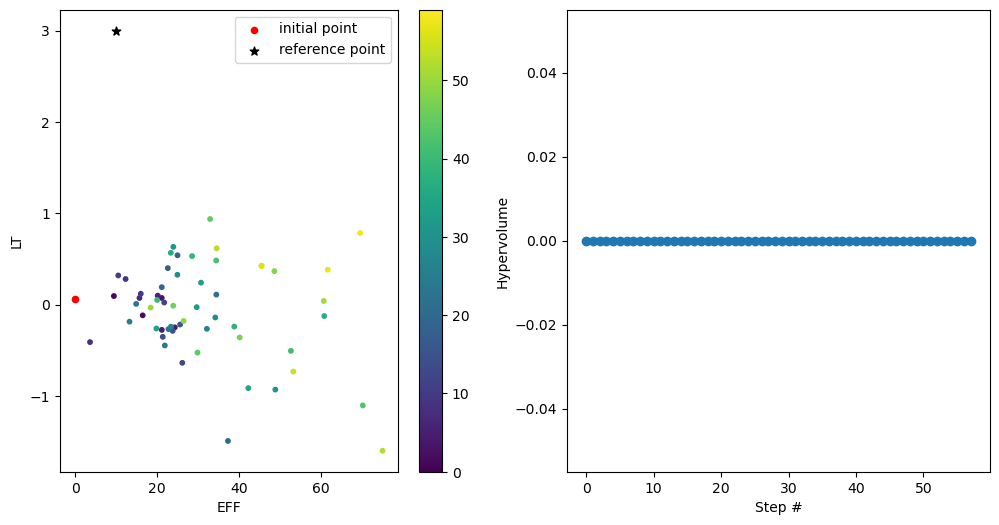

In [15]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i=i,df=opt.data)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

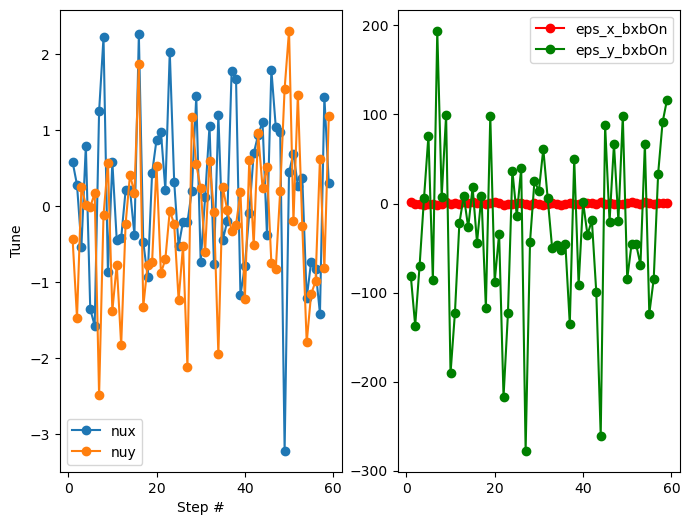

In [16]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [17]:
# This will save optimizer state
if not TEST_MODE:
    opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_{NAME_ROOT}_dump.json')

In [18]:
# Nominal (i.e., design) sextupole settings:
opt.generate_at({k:0.0 for k in variables.keys()})
opt.evaluate_data()

[INFO ][17:30:37.806 optimizer.  573] Evaluating 1 inputs
[DEBUG][17:30:37.807 evaluators  193] Data kwargs: row={'SH1N': 0.0, 'SH3N': 0.0, 'SH4N': 0.0, 'SL1N': 0.0, 'SL2N': 0.0, 'SL3N': 0.0, 'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.0, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[DEBUG][17:30:37.808 evaluators  211] Result: output={'result': {'LT': 0.4053152007963068, 'EFF': 0.03539227058871252, '_nux': -0.3793556943699227, '_nuy': 1.3647412178456588, '_eps_x_bxbOn': 2.0191196999107413, '_eps_y_bxbOn': -2.286755049326576}, 'exception': None, 'traceback': '', 'wall_time': 7.860001642256975e-05, 'cpu_time': 0.0}
[DEBUG][17:30:37.809 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][17:30:37.869 optimizer. 1286] Dumped state to [C:\Users\boss\.apsopt\2023_12_16-17_30_33-aps_moga-0d5b666fc4-673dc46d\dump_auto_00053.json] in [0.05640]s


MOGA add_data (+1): len(self._offspring)=4/8


In [19]:
with pd.option_context('display.max_rows', 500):
    display(opt.data)

,SH1N,SH3N,SH4N,SL1N,SL2N,SL3N,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,traceback,wall_time,cpu_time,valid,LT,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,,0.000137,0.000000,True,0.059651,-0.069122,0.584610,-0.430232,1.530979,-0.809600
2,0.007275,-0.003276,0.001839,-0.001359,0.003520,-0.002979,-0.012187,0.021491,-0.010108,-0.000423,...,,0.000097,0.000000,True,0.093803,9.408403,0.281850,-1.468082,-0.585669,-1.370664
3,-0.013607,0.007010,-0.012991,0.001392,-0.015322,0.018557,0.007942,-0.009508,0.024360,0.002330,...,,0.000088,0.000000,True,-0.117676,16.452778,-0.532134,0.259526,-0.024198,-0.696398
4,0.020145,0.003699,-0.000111,-0.015998,0.029138,0.043712,0.016892,0.000493,-0.024948,0.008058,...,,0.000090,0.000000,True,0.073175,21.105389,0.798353,0.014362,-1.612822,0.061961
5,-0.026826,-0.008512,0.014719,0.015953,-0.044109,-0.023472,-0.022064,-0.027556,0.009505,-0.005675,...,,0.000062,0.000000,True,-0.248973,24.310371,-1.352867,-0.005383,-0.579585,0.761976
6,-0.017657,0.001219,0.019720,-0.013885,-0.005994,-0.036449,-0.024365,0.014675,0.019705,-0.007896,...,,0.000077,0.000000,True,-0.276664,21.130116,-1.570585,0.169272,-0.083593,-0.862173
7,0.025622,-0.006051,-0.006981,0.013847,0.014465,0.029329,0.029422,-0.017594,-0.005457,0.005818,...,,0.000062,0.000000,True,0.098412,20.127631,1.247242,-2.484566,-1.807260,1.939981
8,-0.000487,-0.000816,-0.018389,-0.008577,-0.028242,0.010940,0.004669,0.022608,0.004854,0.000023,...,,0.000055,0.000000,True,0.072362,15.660179,2.222804,-0.115321,-0.799541,0.077387
9,-0.000484,0.000000,0.000000,-0.000017,-0.027358,-0.000077,0.000000,0.000000,0.000000,0.000000,...,,0.000070,0.000000,True,-0.410790,3.566941,-0.869968,0.565635,1.415478,0.994689
10,-0.000003,-0.000816,-0.018389,-0.008560,-0.000883,0.011017,0.004669,0.022608,0.004854,0.000023,...,,0.000083,0.000000,True,0.280339,12.270230,0.584155,-1.375072,-0.997371,-1.908250
